In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from pathlib import Path
from PIL import Image
from torchvision import transforms
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
# SET RANDOM SEEDS
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [3]:
class HogDataset(Dataset):
    """
    Dataset for loading PNG images for HOG detection.
    
    Expected naming convention:
    - HOG present: hog*.png
    - HOG not present: not*.png
    """
    def __init__(self, folder_path, transform=None, augment=True):
        self.image_paths = list(Path(folder_path).glob('*.png'))
        
        if augment:
            # Strong augmentation for small dataset
            self.transform = transforms.Compose([
                transforms.Resize((500, 500)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((500, 500)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        
        # Convert to grayscale if not already
        if img.mode != 'L':
            img = img.convert('L')
        
        # Extract label from filename
        filename = img_path.name.lower()
        if filename.startswith('hog'):
            label = 1  # HOG present
        elif filename.startswith('not'):
            label = 0  # HOG not present
        else:
            raise ValueError(f"Unknown label format in {filename}. Expected 'hog*' or 'not*'.")
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [4]:
class HogDetectionCNN(nn.Module):
    """
    Lightweight CNN for HOG detection on 500x500 images.
    Designed for small datasets with heavy regularization.
    
    Architecture:
    - 4 convolutional blocks with max pooling
    - Each block: Conv -> BatchNorm -> ReLU -> MaxPool -> Dropout
    - Small fully connected classifier to prevent overfitting
    """
    def __init__(self, num_classes=2, in_channels=1):
        super(HogDetectionCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1: 500 -> 250
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
            
            # Block 2: 250 -> 125
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
            
            # Block 3: 125 -> 62
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
            
            # Block 4: 62 -> 31
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
        )
        
        # After 4 pooling layers: 500 -> 250 -> 125 -> 62 -> 31
        # Feature map size: 128 * 31 * 31 = 122,752
        # Using smaller classifier to reduce parameters for small dataset
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 31 * 31, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """
    Validate the model.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

In [13]:
# ===================== CONFIGURATION =====================
DATA_PATH = "/Users/lawsonlevin/ML/project3/CNN"  

# Hyperparameters - optimized for small dataset (50 images)
BATCH_SIZE = 4  # Small batch size for small dataset
LEARNING_RATE = 0.001
NUM_EPOCHS = 150  # More epochs for small dataset
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

# ===================== LOAD DATA =====================
print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

temp_dataset = HogDataset(DATA_PATH, augment=False)
all_indices = list(range(len(temp_dataset)))

# Check label distribution
labels = [temp_dataset[i][1] for i in range(len(temp_dataset))]
print(f"\nDataset size: {len(temp_dataset)}")
print(f"HOG present (hog*): {labels.count(1)}")
print(f"HOG not present (not*): {labels.count(0)}")

# Stratified split to maintain class balance
label_indices = defaultdict(list)
for idx, label in enumerate(labels):
    label_indices[label].append(idx)

# Split each class 80-20
train_indices = []
val_indices = []
for label, indices in label_indices.items():
    split_point = int(0.8 * len(indices))
    train_indices.extend(indices[:split_point])
    val_indices.extend(indices[split_point:])

print(f"\nStratified split:")
print(f"Train: {len(train_indices)} samples")
print(f"Val: {len(val_indices)} samples")

# Create separate dataset instances with/without augmentation
train_dataset = HogDataset(DATA_PATH, augment=True)
val_dataset = HogDataset(DATA_PATH, augment=False)

# Create subsets
train_dataset = Subset(train_dataset, train_indices)
val_dataset = Subset(val_dataset, val_indices)

# Verify class distribution
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
val_labels = [val_dataset[i][1] for i in range(len(val_dataset))]
print(f"\nTrain - HOG present: {train_labels.count(1)}, HOG not present: {train_labels.count(0)}")
print(f"Val - HOG present: {val_labels.count(1)}, HOG not present: {val_labels.count(0)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check image properties
sample_img, _ = temp_dataset[0]
in_channels = sample_img.shape[0]
print(f"\nImage channels: {in_channels}")
print(f"Image size: {sample_img.shape[1]}x{sample_img.shape[2]}")

# ===================== INITIALIZE MODEL =====================
print("\n" + "="*60)
print("INITIALIZING MODEL")
print("="*60)
model = HogDetectionCNN(num_classes=2, in_channels=in_channels).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Ratio of parameters to training samples: {trainable_params/len(train_dataset):.1f}:1")

# Loss and optimizer with class weights for balanced learning
class_counts = [train_labels.count(0), train_labels.count(1)]
class_weights = torch.tensor([1.0/count for count in class_counts], device=DEVICE)
class_weights = class_weights / class_weights.sum()  # Normalize
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Strong weight decay for small dataset to prevent overfitting
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                  factor=0.5, patience=10)

# ===================== TRAINING LOOP =====================
best_val_acc = 0.0
patience_counter = 0
max_patience = 25  # Increased patience for small dataset

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

training_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_preds, val_labels_list = validate(model, val_loader, criterion, DEVICE)
    
    # Store history
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Show prediction distribution every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"  Val predictions - No HOG: {val_preds.count(0)}, HOG present: {val_preds.count(1)}")
        print(f"  Val actual - No HOG: {val_labels_list.count(0)}, HOG present: {val_labels_list.count(1)}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_hog_model_500x500.pth')
        print(f"  ✓ Saved best model with val acc: {val_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= max_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break
    
    print("-" * 60)

print(f"\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Using device: cpu
PyTorch version: 2.8.0

LOADING DATA

Dataset size: 50
HOG present (hog*): 25
HOG not present (not*): 25

Stratified split:
Train: 40 samples
Val: 10 samples

Train - HOG present: 20, HOG not present: 20
Val - HOG present: 5, HOG not present: 5

Image channels: 1
Image size: 500x500

INITIALIZING MODEL
Total parameters: 15,843,042
Trainable parameters: 15,843,042
Ratio of parameters to training samples: 396076.0:1

STARTING TRAINING
Epoch [1/150]
  Train Loss: 35.3099 | Train Acc: 40.00%
  Val Loss: 7.5429 | Val Acc: 50.00%
  LR: 0.001000
  ✓ Saved best model with val acc: 50.00%
------------------------------------------------------------
Epoch [2/150]
  Train Loss: 29.5050 | Train Acc: 47.50%
  Val Loss: 0.7221 | Val Acc: 50.00%
  LR: 0.001000
------------------------------------------------------------
Epoch [3/150]
  Train Loss: 21.0109 | Train Acc: 45.00%
  Val Loss: 15.3816 | Val Acc: 50.00%
  LR: 0.001000
--------------------------------------------------------

In [14]:
# ===================== FINAL ANALYSIS =====================
print("\n" + "="*60)
print("FINAL VALIDATION RESULTS")
print("="*60)

# Load best model
model.load_state_dict(torch.load('best_hog_model_500x500.pth'))
_, final_acc, final_preds, final_labels = validate(model, val_loader, criterion, DEVICE)

print(f"Final accuracy: {final_acc:.2f}%")
print(f"Predictions - No HOG: {final_preds.count(0)}, HOG present: {final_preds.count(1)}")
print(f"Actual - No HOG: {final_labels.count(0)}, HOG present: {final_labels.count(1)}")

# Per-class accuracy
correct_0 = sum((p == l == 0) for p, l in zip(final_preds, final_labels))
correct_1 = sum((p == l == 1) for p, l in zip(final_preds, final_labels))
total_0 = final_labels.count(0)
total_1 = final_labels.count(1)

print(f"\nPer-class accuracy:")
print(f"  No HOG (0): {correct_0}/{total_0} = {100*correct_0/total_0 if total_0 > 0 else 0:.1f}%")
print(f"  HOG present (1): {correct_1}/{total_1} = {100*correct_1/total_1 if total_1 > 0 else 0:.1f}%")


FINAL VALIDATION RESULTS
Final accuracy: 70.00%
Predictions - No HOG: 6, HOG present: 4
Actual - No HOG: 5, HOG present: 5

Per-class accuracy:
  No HOG (0): 4/5 = 80.0%
  HOG present (1): 3/5 = 60.0%


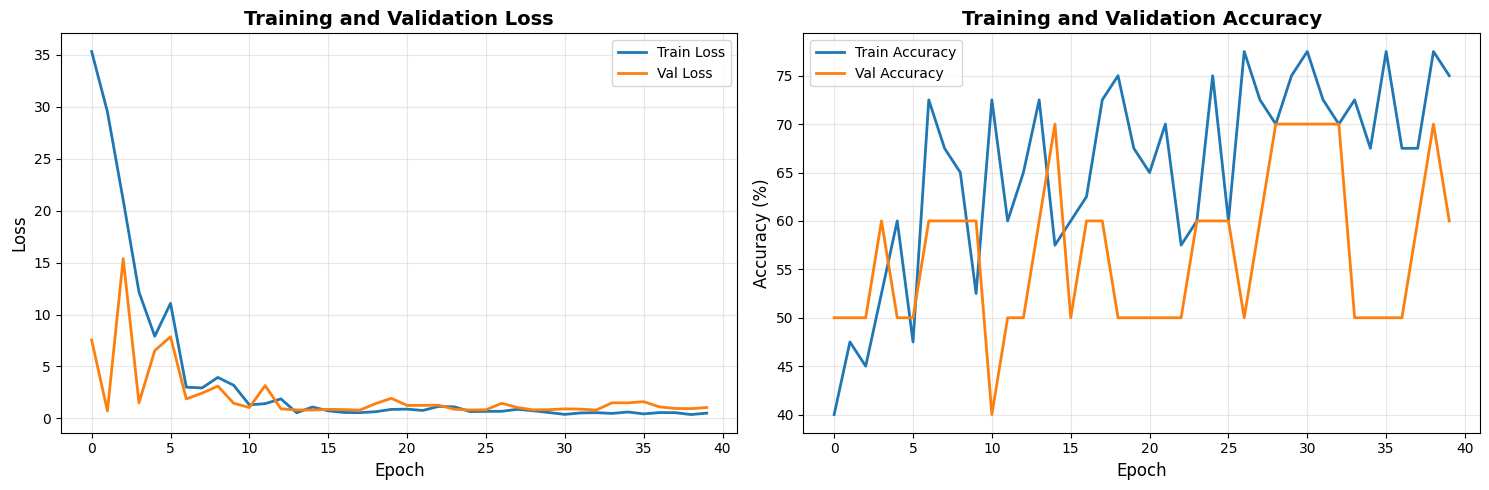


Training visualization saved as 'hog_training_history_500x500.png'


In [15]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(training_history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(training_history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(training_history['train_acc'], label='Train Accuracy', linewidth=2)
ax2.plot(training_history['val_acc'], label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hog_training_history_500x500.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTraining visualization saved as 'hog_training_history_500x500.png'")

In [ ]:
def predict_single_image(model, image_path, device):
    """
    Predict whether HOG is present in a single PNG image.
    
    Args:
        model: Trained model
        image_path: Path to PNG image
        device: torch device
    
    Returns:
        prediction: 0 (no HOG) or 1 (HOG present)
        confidence: probability of predicted class
    """
    model.eval()
    
    # Load and preprocess image
    img = Image.open(image_path)
    if img.mode != 'L':
        img = img.convert('L')
    
    transform = transforms.Compose([
        transforms.Resize((500, 500)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    prediction = predicted.item()
    confidence = confidence.item()
    
    label_map = {0: 'No HOG', 1: 'HOG Present'}
    
    print(f"Image: {Path(image_path).name}")
    print(f"Prediction: {label_map[prediction]}")
    print(f"Confidence: {confidence*100:.2f}%")
    
    return prediction, confidence


predict_single_image(model, r"C:\Users\Alex\Pictures\Screenshots\Screenshot 2025-11-14 153441.png", DEVICE)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Alex\\Pictures\\Screenshots\\Screenshot 2025-11-14 153441.png'

In [11]:
def predict_and_visualize_batch(model, folder_path, device, num_images=6):
    """
    Predict HOG presence for multiple images and visualize results.
    """
    model.eval()
    
    image_paths = list(Path(folder_path).glob('*.png'))[:num_images]
    
    if len(image_paths) == 0:
        print("No PNG images found in the folder!")
        return
    
    rows = (len(image_paths) + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
    axes = axes.flatten() if len(image_paths) > 1 else [axes]
    
    transform = transforms.Compose([
        transforms.Resize((500, 500)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    for idx, img_path in enumerate(image_paths):
        # Load image
        img = Image.open(img_path)
        img_display = img.copy()
        if img.mode != 'L':
            img = img.convert('L')
        
        # Predict
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(img_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
        
        prediction = predicted.item()
        conf = confidence.item()
        
        label_map = {0: 'No HOG', 1: 'HOG Present'}
        color = 'green' if prediction == 1 else 'red'
        
        # Display
        axes[idx].imshow(img_display, cmap='gray')
        axes[idx].set_title(f"{img_path.name}\n{label_map[prediction]} ({conf*100:.1f}%)",
                           fontsize=10, color=color, fontweight='bold')
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(image_paths), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('hog_predictions_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Visualization saved as 'hog_predictions_visualization.png'")


predict_and_visualize_batch(model, r"C:\Users\Alex\Downloads\ValidationIMG", DEVICE, num_images=5)

NameError: name 'model' is not defined